# NSU 2022/23 – prva domača naloga

Na voljo sta dve nalogi, osnovna in napredna. Vsaka je vredna 10 točk. Rešuješ lahko samo
osnovno nalogo, ali pa obe.
Podatkovje podatki.csv je bilo vzeto s strani https://www.openml.org/, nato pa malo spremenjeno: 1. Izbrisane so bile nekatere značilke, vrstni red preostalih pa je bil premešan. 2 Izbrisani so bili nekateri primeri, vrstni red preostalih pa je bil premešan. 3. Vrednosti stolpcev so bile
spremenjene, tako da ne morejo bistveno vplivati na lastnosti podatkov.

Vedi, da za število izbrisov velja naslednje:
- Izbrisali smo največ 100 značilk.
- Izbrisali smo največ 1000 primerov.

Na koncu smo vse stolpce še preimenovali. Ciljna spremenljivka v podatkih nosi ime y in je
dvojiška. Ker je precej neuravnotežena, uporabi za ocenjevanje zmogljivosti modelov ploščino pod
ROC krivuljo namesto točnosti.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("podatki.csv")
print(df)
#print(df.describe())

df["y"] = df["y"].replace(["teamEdward", "teamJacob"], ["1","0"])
df["y"] = pd.to_numeric(df["y"])
#print(df.dtypes)

        x1    x2    x3    x4     x5     x6    x7     x8    x9    x10  ...  \
0      2.0  2.12   3.0  11.0   7.56  54.81  14.0   69.0  10.0  11.13  ...   
1      2.0  2.50   2.0   3.0   2.00  20.13  12.0   15.0  13.0   9.50  ...   
2      5.0  2.32   6.0  11.0  22.00  25.15  20.0   52.0  40.0  31.25  ...   
3      2.0  2.17  56.0  14.0  83.82  31.79  13.0  141.0  13.0  10.94  ...   
4      2.0  2.36   2.0   3.0   2.00  26.22  18.0   15.0  16.0  14.71  ...   
...    ...   ...   ...   ...    ...    ...   ...    ...   ...    ...  ...   
1198  13.0  2.14  19.0  33.0  29.45  73.39  20.0  137.0  63.0  26.46  ...   
1199   6.0  2.27   2.0   5.0  38.36  22.85  11.0   18.0  11.0   7.00  ...   
1200   6.0  2.22  13.0  24.0  33.91  45.42  18.0   73.0  37.0  16.61  ...   
1201   3.0  2.13   5.0   9.0  17.38  24.30  14.0   39.0  14.0  15.80  ...   
1202  14.0  2.10  14.0  18.0  74.73  59.37  14.0   53.0  21.0   8.72  ...   

        x22       x23      x24      x25   x26   x27  x28   x29   x30  \
0  

## 1 Izbira metode in optimizacija hiperparametrov

### 1.1 Ročno
Ročno poišči metodo strojenga učenja, ki na danih podatkih deluje dobro. Nastavi tudi njene
hiperparametre, tako da bo delovala čim boljše.

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
np.random.seed(42)

X = df.drop("y", axis=1)
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
pred_prob = tree.predict_proba(X_test)
print(roc_auc_score(y_test, pred_prob[:,1]))

hiperparametri = {"max_depth": [2+3*i for i in range(5)],
                  "min_samples_split": [2+20*i for i in range(5)]}

model = DecisionTreeClassifier()
gs = GridSearchCV(model, hiperparametri, scoring="roc_auc", cv=5, refit=True)
gs.fit(X_train, y_train)
gs.best_params_


0.8006230529595016


{'max_depth': 8, 'min_samples_split': 82}

Ploscina pod ROC krivuljo:
0.9212530287296643


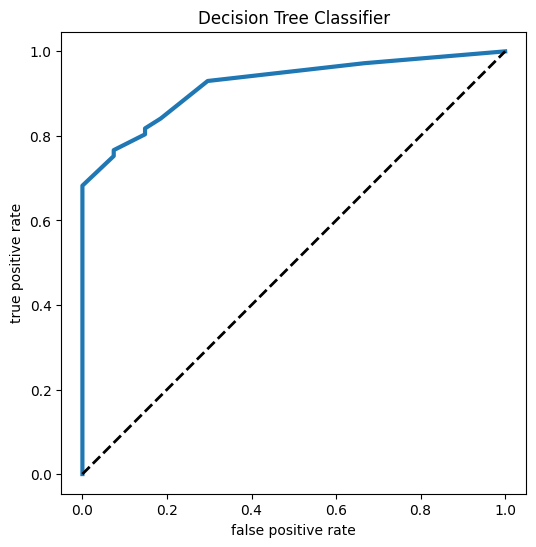

In [6]:
tree_best = DecisionTreeClassifier(max_depth=8, min_samples_split=82)
tree_best.fit(X_train, y_train)

pred_best = tree_best.predict_proba(X_test)
print("Ploscina pod ROC krivuljo:")
print(roc_auc_score(y_test, pred_best[:,1]))

fpr, tpr, thr = roc_curve(y_test, pred_best[:,1])

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=3)
plt.plot([0,1], [0,1], "k--", lw=2)
plt.title("Decision Tree Classifier")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("equal")
plt.show()

### 1.2 Avtomatizirano
Uporabi orodje za avtomatizirano strojno učenje (kot je hyperopt) da poiščeš najboljšo metodo
strojnega učenja in najboljše vrednosti hiperparametrov za dane podatke. Izberi vsaj tri klasifikacijske
algoritme. Vsak od njih naj ima vsaj en hiperparameter, katerega optimalno vrednost
je treba najti. Vsaj en od algoritmov naj ima več kot le en hiperparameter. Optimizacijo hiperparametrov
izvedi s prečnim preverjanjem, zmogljivost izbranega algoritma z optimalno konfiguracijo
parametrov pa preizkusi na testni množici. Primerjaj zmogljivost modela, ki si ga nastavil
sam, ter modela, izbranega in optimiziranega avtomatsko. Ne pozabi, za ocenjevanje zmogljivosti
uporabljaj ploščino pod ROC krivuljo.

In [8]:
from hyperopt import hp, tpe, fmin, Trials, space_eval
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

gnezdeni_prostor = {
    "algo": hp.choice('algo', [
        {
            'ime': 'tree',
            'max_depth': hp.choice('max_depth', [2, 4, 8, 16, 32]),
            'min_samples_leaf': hp.qloguniform('min_samples_leaf', 1, 8, 1),
            'min_samples_split': hp.qloguniform('min_samples_split', 1, 8, 1)
        },
        {
            'ime': 'forest',
            'n_estimators': hp.choice("n_estimators", [3, 5, 7, 10, 13]),
            'criterion': hp.choice('criterion', ["gini", "entropy"]),
        },
        {
            'ime': 'svm',
            'C': hp.lognormal('C', 0, 1),
        },
    ])
}

Text(0, 0.5, 'AUC score')

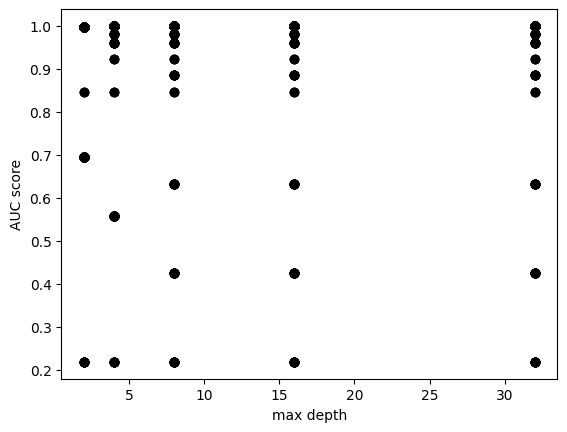

In [9]:
auc = []
depth = [2, 4, 8, 16, 32]
for k in depth:
    tree = DecisionTreeClassifier(max_depth=k, min_samples_split=132, min_samples_leaf=9)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    pred_prob = tree.predict_proba(X_test)
    auc += [pred_prob[:,1]]

plt.plot(depth, auc, "ko")
plt.xlabel("max depth")
plt.ylabel("AUC score")



Text(0, 0.5, 'AUC score')

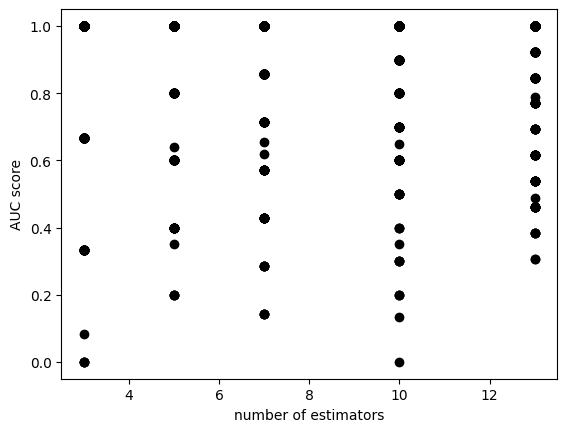

In [10]:
auc = []
est = [3, 5, 7, 10, 13]
for k in est:
    forest = RandomForestClassifier(n_estimators=k, criterion="gini")
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    pred_prob = forest.predict_proba(X_test)
    auc += [pred_prob[:,1]]

plt.plot(est, auc, "ko")
plt.xlabel("number of estimators")
plt.ylabel("AUC score")

In [11]:
def kriterijska_funkcija(parametri):
    a = parametri["algo"]
    ime_algoritma = a["ime"]
    if ime_algoritma == "forest":
        np.random.seed(42)
        model = RandomForestClassifier(n_estimators=a["n_estimators"],
                                       criterion=a["criterion"])
    elif ime_algoritma == "tree":
        model = DecisionTreeClassifier(max_depth=a["max_depth"], 
                                       min_samples_leaf=int(a["min_samples_leaf"]),
                                       min_samples_split=int(a["min_samples_split"]))
    elif ime_algoritma == "svm":
        model = SVC(C = a["C"])
    else:
        raise ValueError("Napacne nastavitve!")
    score = cross_validate(model, X, y, cv=5, scoring="roc_auc")
    avg_score = sum(score["test_score"])/5
    return 1 - avg_score

trials = Trials()
best = fmin(fn=kriterijska_funkcija,
            space=gnezdeni_prostor,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
best = space_eval(gnezdeni_prostor, best)
best_value = kriterijska_funkcija(best)

print("Optimizirane vrednosti")
print(best, best_value)


100%|██████████| 100/100 [00:24<00:00,  4.14trial/s, best loss: 0.09324777390631045]
Optimizirane vrednosti
{'algo': {'criterion': 'entropy', 'ime': 'forest', 'n_estimators': 13}} 0.09324777390631045


Ploscina pod ROC krivuljo:
0.9564728279681552


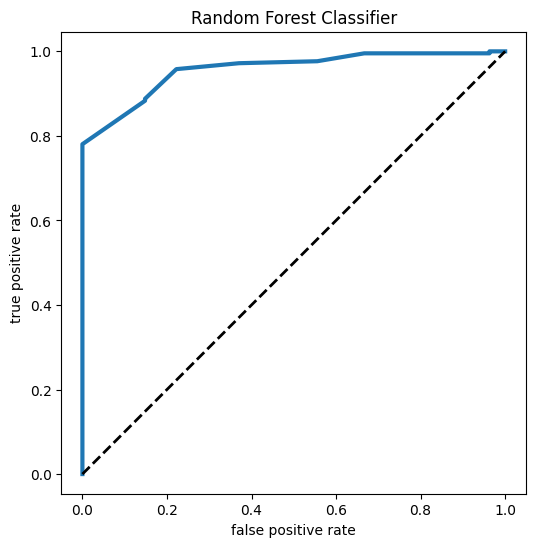

In [12]:
np.random.seed(42) 
forest_best = RandomForestClassifier(n_estimators=13, criterion="gini")
forest_best.fit(X_train, y_train)

pred_best_avt = forest_best.predict_proba(X_test)
print("Ploscina pod ROC krivuljo:")
print(roc_auc_score(y_test, pred_best_avt[:,1]))

# Izračunamo ROC krivuljo
fpr, tpr, thr = roc_curve(y_test, pred_best_avt[:,1])

# Nariščemo ROC krivuljo
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=3)
plt.plot([0,1], [0,1], "k--", lw=2)
plt.title("Random Forest Classifier")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("equal")
plt.show()

## 2 Meta učenje
Izberi si primerne metaznačilke, s katerimi opišeš podatkovja. V prostoru, ki ga te značilke razpenjajo,
s pomočjo openml.org najdi tri podatkovja, ki so najbolj podobna temu iz podatki.csv. Za
iskanje sosedov lahko uporabiš algoritem k najbližjih sosedov (k = 3). Ko najdeš sosede, ugotovi,
kateri algoritem za klasifikacijo se je najbolje odrezal na njih, sodeč po obstoječih rezultatih na
OpenML. Tako dobiš največ tri različne kandidate – za vsakega soseda enega.

Izberi enega od treh kandidatnih algoritmov in ga poženi na podatki.csv. Njegovo zmogljivost
oceni na isti testni množici kot v prvem delu domače naloge.

Za konec še primerjaj zmogljivosti algoritma, izbranega s pomočjo meta učenja s tistim, ki si
ga izbral a ročno, ter s tistim, ki si ga izbral a avtomatizirano. Je bilo meta učenje koristno? Bi
zdaj v prvem delu naloge naredil kaj drugače?

In [13]:
import openml as oml

d = oml.datasets.list_datasets(number_instances = "1202..2202", number_features = "30..130", output_format="dataframe")
data_ids = list(d["did"])
print(d)


         did                                               name  version  \
14        14                                      mfeat-fourier        1   
16        16                                     mfeat-karhunen        1   
22        22                                      mfeat-zernike        1   
315      315                                           us_crime        1   
930      930                                    colleges_usnews        2   
...      ...                                                ...      ...   
44788  44788  KDDCup09-Upselling_seed_0_nrows_2000_nclasses_...        1   
44789  44789  KDDCup09-Upselling_seed_1_nrows_2000_nclasses_...        1   
44790  44790  KDDCup09-Upselling_seed_2_nrows_2000_nclasses_...        1   
44791  44791  KDDCup09-Upselling_seed_3_nrows_2000_nclasses_...        1   
44792  44792  KDDCup09-Upselling_seed_4_nrows_2000_nclasses_...        1   

      uploader  status format  MajorityClassSize  MaxNominalAttDistinctValues  \
14    

In [14]:
podatkovja_vsa = oml.datasets.get_datasets(data_ids)
print(podatkovja_vsa)

[OpenML Dataset
Name..........: mfeat-fourier
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:20:17
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/14/mfeat-fourier.arff
OpenML URL....: https://www.openml.org/d/14
# of features.: 77
# of instances: 2000, OpenML Dataset
Name..........: mfeat-karhunen
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:20:30
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/16/mfeat-karhunen.arff
OpenML URL....: https://www.openml.org/d/16
# of features.: 65
# of instances: 2000, OpenML Dataset
Name..........: mfeat-zernike
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:21:00
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22/mfeat-zernike.arff
OpenML URL....: https://www.openml.org/d/22
# of features.: 48
# of instances: 2000, OpenML Dataset
Name..........: us_crime
Version.......: 1
Format........: ARFF


In [16]:
podatkovja_ok = {}
for n, podatkovje in enumerate(podatkovja_vsa):
    podatkovje_ime = podatkovje.name
    target = podatkovje.default_target_attribute
    x, y, nominalni, atributi = podatkovje.get_data()

    name_ok = podatkovje_ime not in podatkovja_ok

    targ_ok = target is not None and "," not in target

    i_target = atributi.index(target) if targ_ok else 0
    nomi_ok = nominalni[i_target] and sum(nominalni) == 1
    if name_ok and targ_ok and nomi_ok:
        podatkovja_ok[podatkovje_ime] = n

n_vsa = len(podatkovja_vsa)
n_ok = len(podatkovja_ok)
print(f"Obdrzal sem {n_ok} podatkovij ({100 * n_ok / n_vsa:.1f}%)")

Obdrzal sem 119 podatkovij (48.0%)


In [67]:
from pymfe.mfe import MFE

meta_features = {"name": []}
for podatkovje_ime, n in podatkovja_ok.items():
    x, y, nominal, names = podatkovja_vsa[n].get_data(target=podatkovja_vsa[n].default_target_attribute)
    x = np.array(x)
    y = np.array([str(t) for t in y])

    mfe = MFE(groups=["general", "info-theory"])
    mfe.fit(x, y)
    attribute_names, attribute_values = mfe.extract()

    is_first = len(meta_features) == 1
    meta_features["name"].append(podatkovje_ime)
    for a_name, a_value in zip(attribute_names, attribute_values):
        if is_first:
            meta_features[a_name] = [a_value]
        else:
            meta_features[a_name].append(a_value)
    
pd.DataFrame(data=meta_features, index=None).to_csv("meta_features.csv", index=False)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymfe\_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymfe\_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymfe\_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymfe\_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymfe\_internal.py:1568: UserWarning: It i

In [82]:
df = pd.read_csv("podatki.csv")
df["y"] = df["y"].replace(["teamEdward", "teamJacob"], ["1","0"])
df["y"] = pd.to_numeric(df["y"])

X = df.drop("y", axis=1)
y = df["y"]

x = np.array(X)
y = np.array([str(t) for t in y])
mfe = MFE(groups=["general", "info-theory"])
mfe.fit(x, y)
attribute_names, attribute_values = mfe.extract()

df_features = list(zip(attribute_names, attribute_values))
print(df_features)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymfe\_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")


[('attr_conc.mean', 0.10782646863451376), ('attr_conc.sd', 0.1009351989019471), ('attr_ent.mean', 2.7993325529650517), ('attr_ent.sd', 0.7011380143695096), ('attr_to_inst', 0.02493765586034913), ('cat_to_num', 0.0), ('class_conc.mean', 0.019535145762771742), ('class_conc.sd', 0.029033032007713847), ('class_ent', 0.6047202206385474), ('eq_num_attr', 10.095791708413493), ('freq_class.mean', 0.5), ('freq_class.sd', 0.4978548991396557), ('inst_to_attr', 40.1), ('joint_ent.mean', 3.344154527076326), ('joint_ent.sd', 0.7106403843864122), ('mut_inf.mean', 0.05989824652727273), ('mut_inf.sd', 0.04346610317407691), ('nr_attr', 30), ('nr_bin', 0), ('nr_cat', 0), ('nr_class', 2), ('nr_inst', 1203), ('nr_num', 30), ('ns_ratio', 45.73479968550442), ('num_to_cat', nan)]


In [102]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=3)

ucni = pd.DataFrame.from_dict(meta_features)
ucni = ucni.drop("num_to_cat", axis=1)
knn.fit(ucni)



NearestNeighbors(n_neighbors=3)

In [129]:
podatki = pd.DataFrame(attribute_values)
podatki = podatki.dropna().transpose()
distances, indices = knn.kneighbors(podatki)
print(indices)

[[10 16 19]]


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [151]:
podatkovja = pd.DataFrame(podatkovja_ok.keys())
najbolsa_tri = list(zip(podatkovja.loc[10], podatkovja.iloc[16], podatkovja.iloc[19]))
print(najbolsa_tri)

[('ibm-employee-performance', 'amazon-commerce-reviews_seed_0_nrows_2000_nclasses_10_ncols_100_stratify_True', 'amazon-commerce-reviews_seed_3_nrows_2000_nclasses_10_ncols_100_stratify_True')]
